## Introducción a la Inteligencia Artificial

##### Microproyecto 3: Aprendizaje supervisado - Arboles de decisión y clasificación bayesiana


### **Integrantes equipo 15**

Julián Orrego Martínez

---
Stefany Cantero Cardenas

---
Laura Melissa Neira

---

#PREDECIR DIABETES

Importamos las librerías necesarias para trabajar con el dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from subprocess import check_call
from IPython.display import Image as PImage

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# **1. Descripción y preprocesamiento de los datos**

### Descripción de los datos

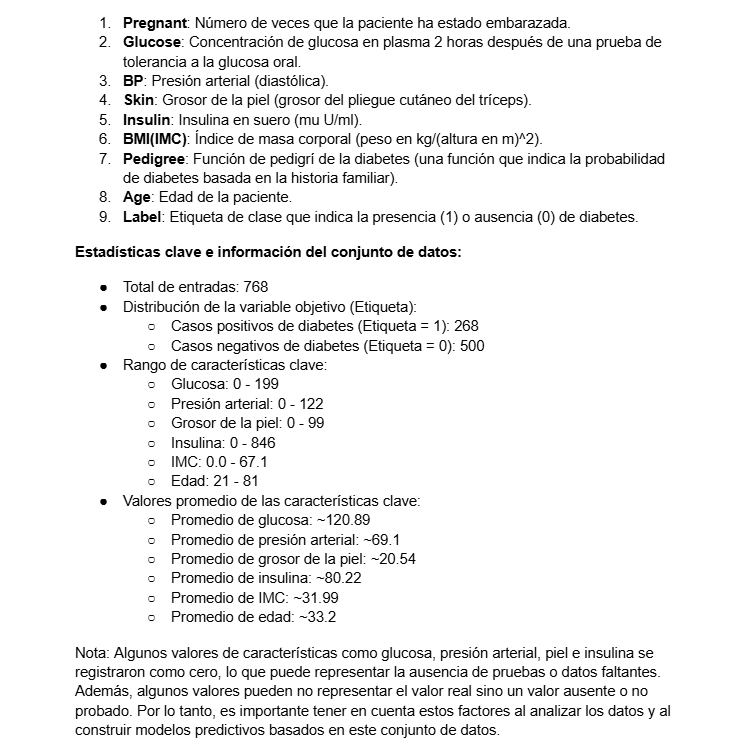

In [3]:
# Cargar datos

df = pd.read_csv('/content/pima-indians-diabetes.csv')

In [4]:
# Visualizar los primeros registros

df.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Verificar la cantidad de datos

df.shape

(768, 9)

In [6]:
# Verificar si hay valores faltantes o nulos en cada feature

df.isnull().sum()

,0
pregnant,0
glucose,0
bp,0
skin,0
insulin,0
bmi,0
pedigree,0
age,0
label,0


###**Análisis de las características**

array([[<Axes: title={'center': 'pregnant'}>,
        <Axes: title={'center': 'glucose'}>,
        <Axes: title={'center': 'bp'}>],
       [<Axes: title={'center': 'skin'}>,
        <Axes: title={'center': 'insulin'}>,
        <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'pedigree'}>,
        <Axes: title={'center': 'age'}>, <Axes: >]], dtype=object)

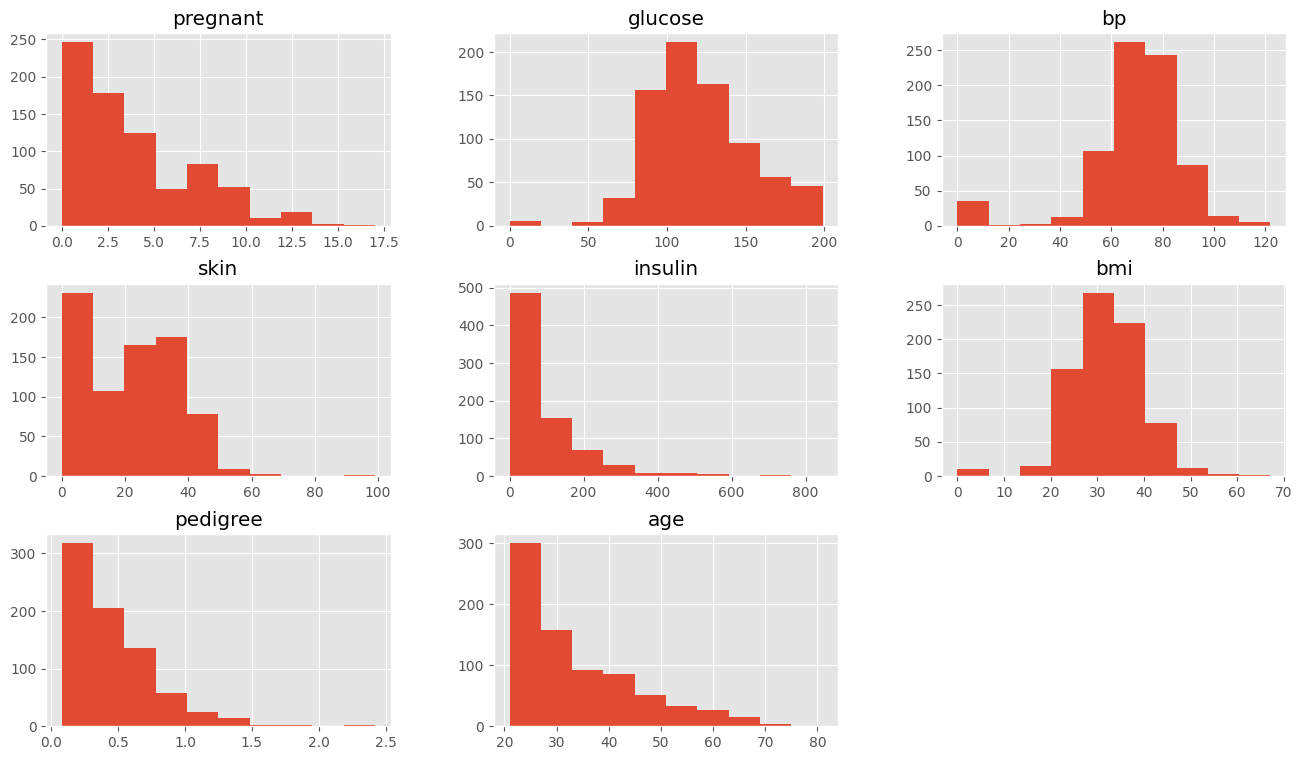

In [7]:
# Visualizar la distribución de los datos en cada característica

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 9)
df.iloc[:, :-1].hist()

In [8]:
# Estadísticas descriptivas para cada feature menos el target

df.iloc[:, :-1].describe()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [9]:
# Contar valores en 0 en cada feature menos el target

zero_counts = (df.iloc[:, :-1] == 0).sum()
zero_counts

,0
pregnant,111
glucose,5
bp,35
skin,227
insulin,374
bmi,11
pedigree,0
age,0


Debido a que hay una cantidad significativa de valores en cero en las variables bp, skin, insulin y bmi se realiza una imputación de valores para estas características usando la mediana del resto de los registros y el módulo SimpleImputer de scikit-learn. Para las variables pregnant, glucose, pedigree y age no se considera este procedimiento ya que estas pueden tener valores en cero por su naturaleza misma.

In [10]:
# Importar el módulo

from sklearn.impute import SimpleImputer

# Crear copia del dataset

diabetes = df.copy()

In [11]:
# Reemplazar ceros con NaN en las columnas bp, skin, insulin y bmi

diabetes[['bp', 'skin', 'insulin', 'bmi']] = diabetes[['bp', 'skin', 'insulin', 'bmi']].replace(0, np.nan)
diabetes

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122,70.0,27.0,NaN,36.8,0.340,27,0
765,5,121,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126,60.0,NaN,NaN,30.1,0.349,47,1


In [12]:
# Declarar el imputador con la mediana

imputer = SimpleImputer(strategy='median')

# Ajustar el imputador en las columnas bp, skin, insulin y bmi
diabetes[['bp', 'skin', 'insulin', 'bmi']] = imputer.fit_transform(diabetes[['bp', 'skin', 'insulin', 'bmi']])
diabetes

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122,70.0,27.0,125.0,36.8,0.340,27,0
765,5,121,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126,60.0,29.0,125.0,30.1,0.349,47,1


###**Análisis de la distribución de la variable objetivo: label**

In [13]:
# Visualizar la distribución de los datos en label

label_counts = diabetes.groupby('label').size()
label_counts

,0
label,
0,500
1,268


<Axes: xlabel='label'>

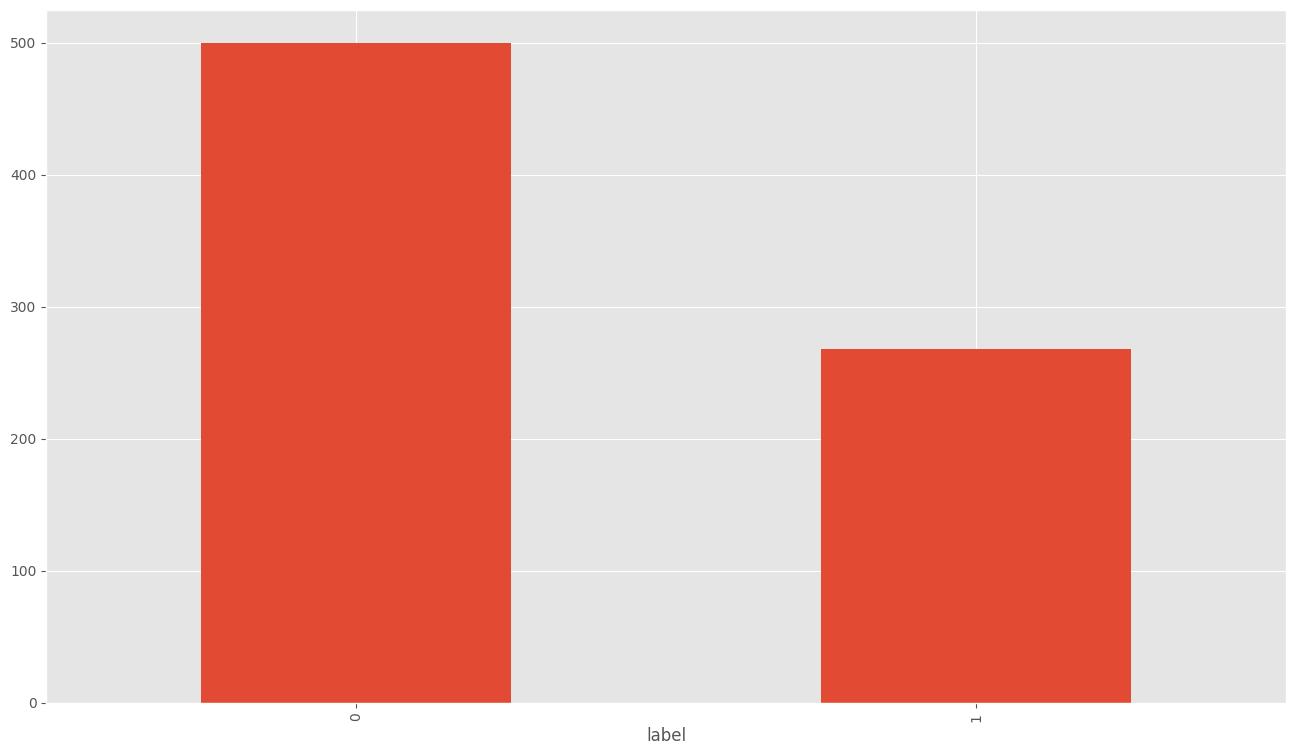

In [14]:
label_counts.plot(kind='bar')

# **2. Árbol de decisión**

In [15]:
# Mezclar los datos aleatoriamente

diabetes = diabetes.sample(frac=1).reset_index(drop=True)

In [16]:
# Variables para la definición de métricas y entrenamiento del modelo

X = np.array(diabetes.drop(['label'], axis=1))
y = np.array(diabetes['label'])

###**Entropía vs Gini**

Para evaluar las métricas Entropía y Gini se elige un valor de 10 folds, de manera que 9 son para entrenamiento y 1 para prueba en cada iteración.

In [17]:
def gini_entropy(df,crit,weight):
  # Configurar la validación cruzada
  cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

  accuracies = []
  max_attributes = len(list(df))
  depth_range = range(1, max_attributes + 1)

  # Testearemos la profundidad de 1 a cantidad de atributos + 1
  for depth in depth_range:
      fold_accuracy = []
      tree_model = tree.DecisionTreeClassifier(
          criterion=crit,
          min_samples_split=20,
          min_samples_leaf=5,
          max_depth=depth,
          class_weight=weight
      )
      for train_index, valid_index in cv.split(X, y):
          X_train, X_test = X[train_index], X[valid_index]
          y_train, y_test = y[train_index], y[valid_index]

          model = tree_model.fit(X_train, y_train)
          valid_acc = model.score(X_test, y_test)  # Calculamos la precisión con el segmento de validación
          fold_accuracy.append(valid_acc)

      # Almacenamos la precisión promedio para cada profundidad
      avg = sum(fold_accuracy) / len(fold_accuracy)
      accuracies.append(avg)

  # Mostramos los resultados obtenidos
  results_df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
  results_df = results_df[["Max Depth", "Average Accuracy"]]

  # Graficar los resultados
  plt.figure(figsize=(10, 6))
  plt.plot(results_df["Max Depth"], results_df["Average Accuracy"], marker="o", linestyle='-')
  plt.xlabel("Max Depth")
  plt.ylabel("Average Accuracy")
  plt.title(f"Accuracy vs. Max Depth ({crit} criterion)")
  plt.grid(True)
  plt.show()

  return results_df

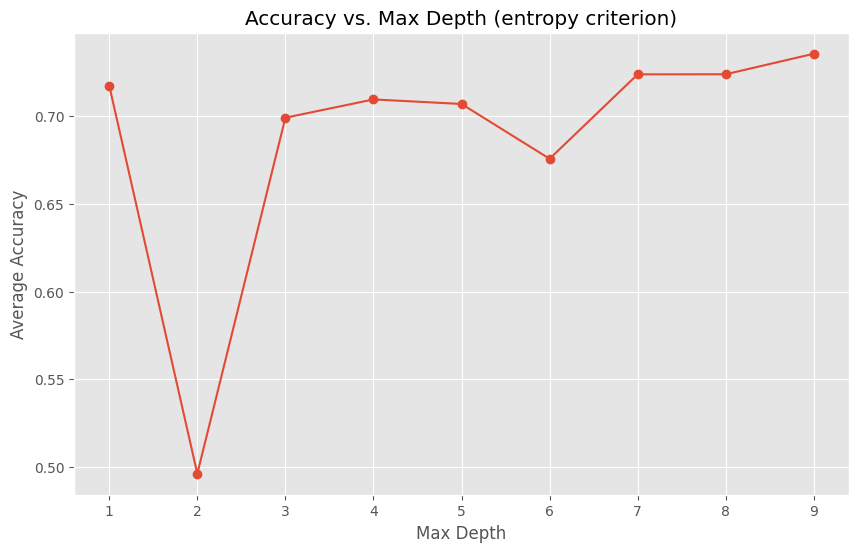

   Max Depth  Average Accuracy
0          1          0.717498
1          2          0.496053
2          3          0.699180
3          4          0.709621
4          5          0.707023
5          6          0.675752
6          7          0.723923
7          8          0.723975
8          9          0.735697


In [18]:
print(gini_entropy(diabetes, 'entropy', {0: 1, 1: 3.5}))

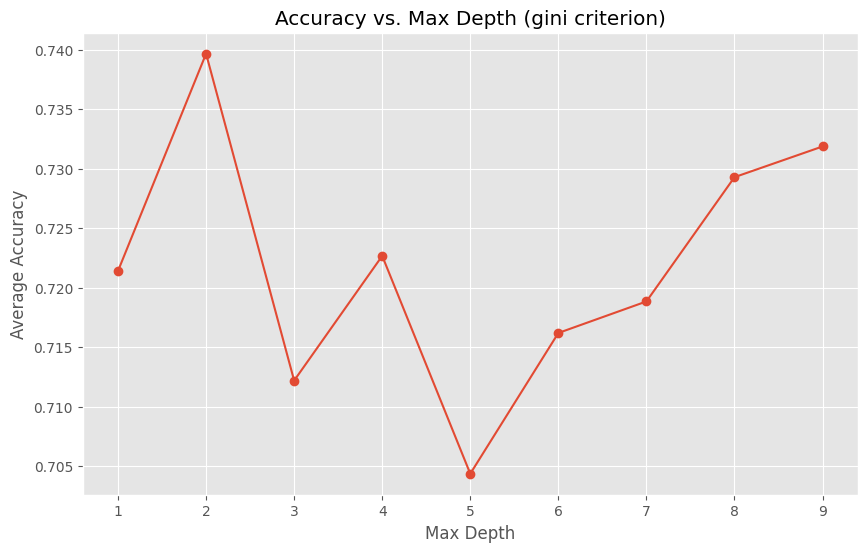

   Max Depth  Average Accuracy
0          1          0.721411
1          2          0.739662
2          3          0.712201
3          4          0.722676
4          5          0.704375
5          6          0.716200
6          7          0.718848
7          8          0.729289
8          9          0.731869


In [19]:
print(gini_entropy(diabetes, 'gini', 'balanced'))

##**Análisis comparativo**

**Entropía**

Precisión Máxima: La precisión promedio más alta con el criterio de entropía es aproximadamente 0.710954, con una profundidad máxima de 1.

La precisión muestra fluctuaciones significativas a medida que aumenta la profundidad con varios picos y valles.

**Índice Gini**

Precisión Máxima: La precisión más alta con el criterio de Gini es aproximadamente 0.747488, con una profundidad máxima de 2.

La precisión también muestra fluctuaciones, pero parece estabilizarse mejor en profundidades mayores en compración con la entropía.

**Elección de métrica**

 En este caso, Gini es más adecuada ya que, alcanza una precisión ligeramente mayor y muestra una tendencia más estable en profundidades mayores.

# **3. Porcentaje de datos usados para entrenamiento y prueba**
Se seleccionó un 75% de los datos para entrenamiento y un 25% para prueba, siguiendo las prácticas comunes en la industria y luego de que se evidenciara una mejor capacidad de generalización con estos valores.

Se probó la opción alternativa de 80% para entrenamiento y 20% para prueba. Sin embargo, al evaluar ambas particiones, se encontró que la primera opción proporcionaba mejores resultados en términos de exactitud (accuracy). Esto se debe a que el tamaño del conjunto de datos debe ser suficiente para que el modelo pueda aprender de manera efectiva y generalizar nuevos datos sin caer en underfitting u overfitting.

In [20]:
# Dividimos los datos para entrenamiento y prueba
x = diabetes.drop(['label'], axis=1)
y = diabetes['label']

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size = 0.25,    #75% entrenamineto, 25% prueba
                                                    stratify = y,
                                                    random_state = 1)

# **4. Variables a usar para la clasificación**

###Matriz de correlación de Pearson

<Axes: title={'center': 'Gráfico de correlación de Pearson'}>

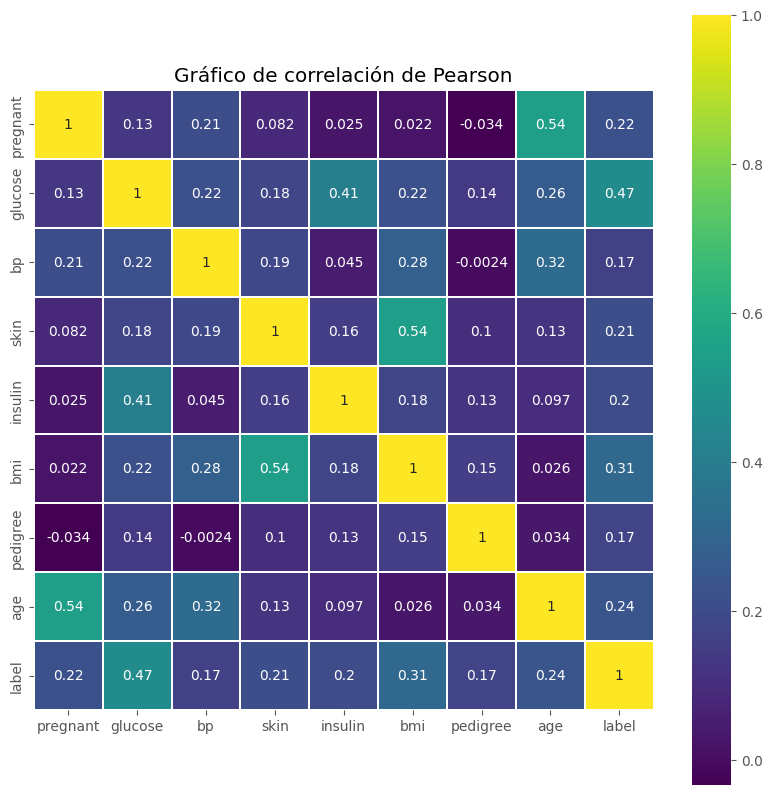

In [21]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Gráfico de correlación de Pearson')
sb.heatmap(diabetes.astype(float).corr(),
           vmax=1.0,
           cmap=colormap,
           annot=True,
           linewidths=0.1,
           linecolor='white',
           square=True)

###SelectKBest: ¿Qué variables tienen mayor impacto que otras a la variable objetivo?

In [22]:
#Mezclar datos, aunque ya se mezclaron mas arriba
diabetes = diabetes.sample(frac=1).reset_index(drop=True)

#Todos los datos excepto la caracteristica objetivo.
x = diabetes.drop(['label'], axis=1)

#CARACTERÍSTICA OBJETIVO
y = diabetes['label']

best=SelectKBest(k=8)

x_new = best.fit_transform(X, y)
x_new.shape
selected = best.get_support(indices=True)
print(x.columns[selected])

Index(['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree',
       'age'],
      dtype='object')


**Análisis**

El resultado de Selectkbest muestra características las caracterísitcas más relevantes para la clasificación, estas características son "pregnant, glucose, skin, bmi y age". Basado en el gráfico de correlación de Pearson las variables más relevantes para la clasificación son estas, debido a su alta puntación en la función f_classif, lo que indica su relevancia en la predicción de la variable objetivo (Y)

Por otro lado, en el gráfico de correlación, se muestra que BMI tiene una fuerte correlación positiva con (Y)

# **5 - 6. Exactitud para diferentes profundidades de árbol, cantidad mínima de muestras por nodo y por hoja**

In [23]:
# Contar cantidad de elementos por clase luego de hacer train_test_split
counts = x_train.copy()
counts['label'] = y_train
label_counts_new = counts.groupby('label').size()
label_counts_new

,0
label,
0,375
1,201


In [24]:
# Crear los pesos con respecto a la clase con mayor tamaño de datos
w = label_counts_new[0] / label_counts_new[1]
w

1.8656716417910448

###**Usando ciclos anidados:**

In [25]:
# Instanciar Árbol de decisión con diferentes profundidades

depth_range = [2,5,6]
var_accuracy = []

for i in depth_range: # Explorar diferentes profundidades
  for j in range(10,30,2):  # Explorar diferentes muestras mínimas por nodo
    for k in range(5,15): # Explorar diferentes muestras mínimas por hoja
      # Instanciar el modelo de árbol de decisión
      decision_tree = tree.DecisionTreeClassifier(
          criterion='gini', # Seleccionamos gini partiendo del análsis anterior
          splitter='best',
          min_samples_split=j,  # Número mínimo de muestras por nodo
          min_samples_leaf=k,    # Número mínimo de muestras por hoja
          max_depth=i,           # Profundidad máxima del árbol
          class_weight={0: 1, 1: w}  # Ajuste del peso de las clases
      )

      # Ajustamos el modelo con los datos
      decision_tree.fit(x_train, y_train)

      # Exactitud en datos de entrenamiento
      y_pred_train = decision_tree.predict(x_train)
      acc_train = accuracy_score(y_train, y_pred_train)

      # Exactitud en datos de prueba
      y_pred_test = decision_tree.predict(x_test)
      acc_test = accuracy_score(y_test, y_pred_test)

      var_accuracy.append((i, j, k, acc_train, acc_test))

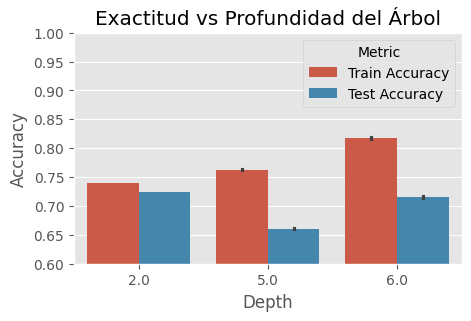

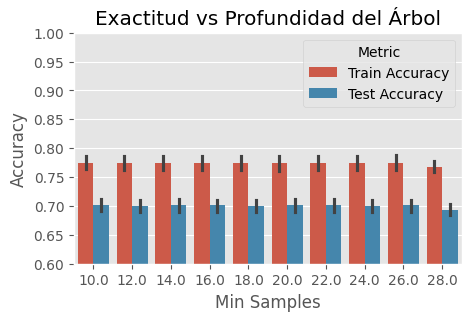

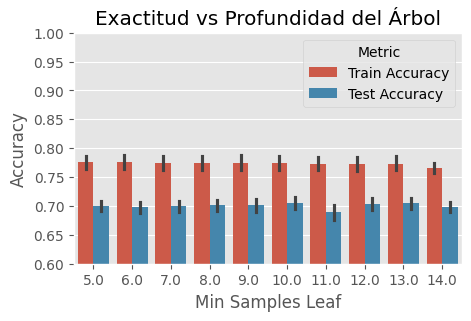

In [26]:
# Convertir resultados a un formato adecuado para graficar
var_accuracy = np.array(var_accuracy)
depths = var_accuracy[:, 0]         # Profundidad del árbol
min_samples = var_accuracy[:, 1]    # Muestras mínimas por nodo
min_samples_leaf = var_accuracy[:, 2]  # Muestras mínimas por hoja
acc_train = var_accuracy[:, 3]      # Exactitud en entrenamiento
acc_test = var_accuracy[:, 4]       # Exactitud en prueba

data = pd.DataFrame({
    'Depth': depths,
    'Min Samples': min_samples,
    'Min Samples Leaf': min_samples_leaf,
    'Train Accuracy': acc_train,
    'Test Accuracy': acc_test
})

def plot_comparison(df, x_col, title):
    # Crear gráfico de barras
    plt.figure(figsize=(5, 3))
    df_melted = df.melt(id_vars=x_col, value_vars=['Train Accuracy', 'Test Accuracy'],
                        var_name='Metric', value_name='Accuracy')
    g = sns.barplot(data=df_melted, x=x_col, y='Accuracy', hue='Metric')

    # Configurar título y etiquetas
    plt.xlabel(x_col)
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.ylim(0.6, 1)
    plt.show()

# Crear gráficos de barras agrupadas
plot_comparison(data, 'Depth', 'Exactitud vs Profundidad del Árbol')
plot_comparison(data, 'Min Samples', 'Exactitud vs Profundidad del Árbol')
plot_comparison(data, 'Min Samples Leaf', 'Exactitud vs Profundidad del Árbol')


###**Usando GridSearchCV:**

In [27]:
from sklearn.model_selection import GridSearchCV

# Instanciar Árbol de decisión con diferentes profundidades

param_grid = {
    'max_depth': [2, 5, 6],
    'min_samples_split': range(10, 30, 2),
    'min_samples_leaf': range(5, 15),
    'class_weight': [{0: 1, 1: w}]
}

# Instanciar el modelo de árbol de decisión
decision_tree = tree.DecisionTreeClassifier(
    criterion='gini', # Seleccionamos gini partiendo del análsis anterior
    splitter='best')

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=decision_tree,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10
)

# Ajustamos el modelo con los datos
grid_search.fit(x_train, y_train)

# Imprimir los mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Evaluar el mejor modelo en datos de entrenamiento
y_pred_train = best_model.predict(x_train)
acc_train = accuracy_score(y_train, y_pred_train)

# Evaluar el mejor modelo en datos de prueba
y_pred_test = best_model.predict(x_test)
acc_test = accuracy_score(y_test, y_pred_test)

print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train))
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test))

Mejores parámetros encontrados:
{'class_weight': {0: 1, 1: 1.8656716417910448}, 'max_depth': 6, 'min_samples_leaf': 14, 'min_samples_split': 24}
Exactitud con datos de entrenamiento: 0.80
Exactitud con datos de pruebas: 0.70


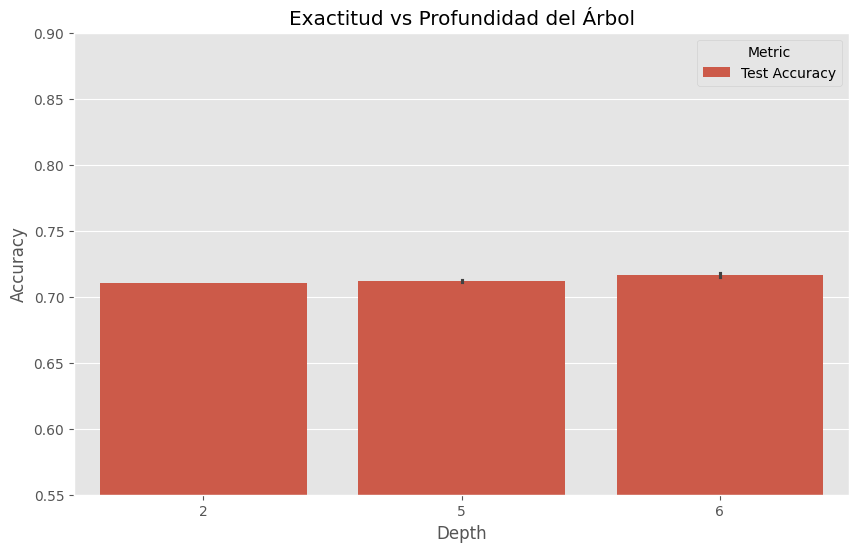

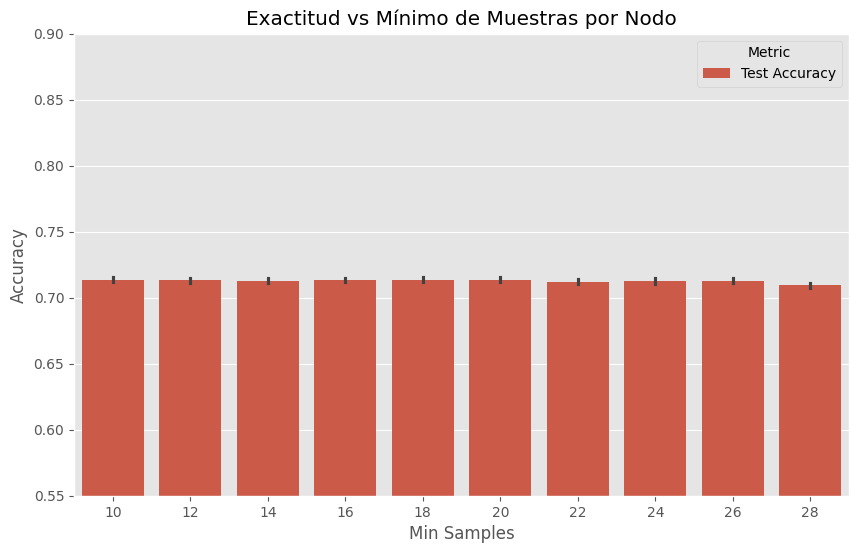

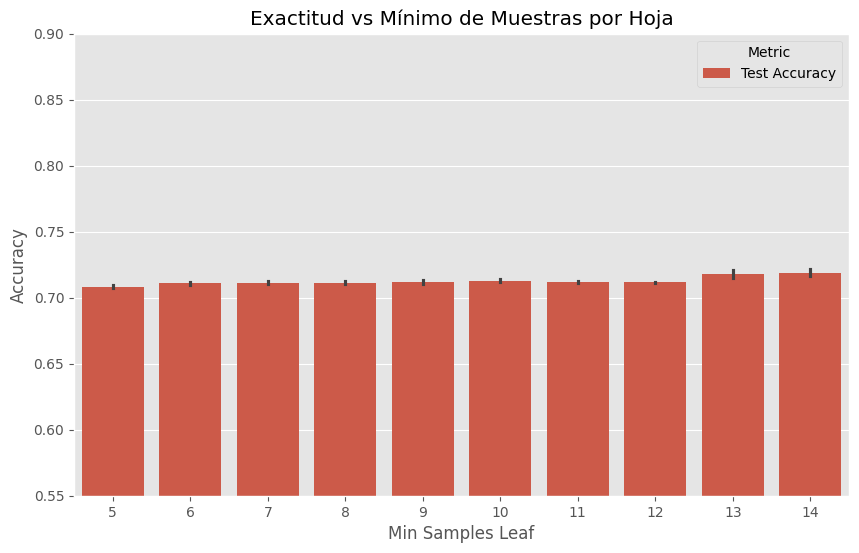

In [28]:
# Convertir resultados a un formato adecuado para graficar
results = grid_search.cv_results_

data = pd.DataFrame({
    'Depth': results['param_max_depth'],
    'Min Samples': results['param_min_samples_split'],
    'Min Samples Leaf': results['param_min_samples_leaf'],
    'Test Accuracy': results['mean_test_score']})

# Función para graficar comparación
def plot_comparison(df, x_col, title):
    # Crear gráfico de barras
    plt.figure(figsize=(10, 6))
    df_melted = df.melt(id_vars=x_col, value_vars=['Test Accuracy'],
                        var_name='Metric', value_name='Accuracy')
    g = sns.barplot(data=df_melted, x=x_col, y='Accuracy', hue='Metric')

    # Configurar título y etiquetas
    plt.xlabel(x_col)
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.ylim(0.55, 0.9)
    plt.show()

# Crear gráficos de barras agrupadas
plot_comparison(data, 'Depth', 'Exactitud vs Profundidad del Árbol')
plot_comparison(data, 'Min Samples', 'Exactitud vs Mínimo de Muestras por Nodo')
plot_comparison(data, 'Min Samples Leaf', 'Exactitud vs Mínimo de Muestras por Hoja')



Una vez utilizados dos métodos, se eligieron los hiperparámetros resultantes de aplicar GridSearchCV. En ambos se evaluaron profundidades de 2, 5 y 6, así como diferentes cantidades mínimas de muestras por nodo (entre 10 y 30) y por hoja (entre 5 y 15). Así, se han seleccionado los siguientes valores:

* Máxima profundidad: 6

* Mínimo de muestras por nodo: 14

* Mínimo de muestras por hoja: 24

* Exactitud con datos de entrenamiento: 0.80

* Exactitud con datos de pruebas: 0.70

In [29]:
# Guardar los mejores parámetros obtenidos en GridSearchCV
best_params = grid_search.best_params_
best_max_depth = best_params['max_depth']
best_min_samples_split = best_params['min_samples_split']
best_min_samples_leaf = best_params['min_samples_leaf']

decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    max_depth=best_max_depth,
    class_weight={0: 1, 1: w}
)

# Ajustar el modelo con los datos de entrenamiento
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 1.8656716417910448}, max_depth=6,
                       min_samples_leaf=14, min_samples_split=24)

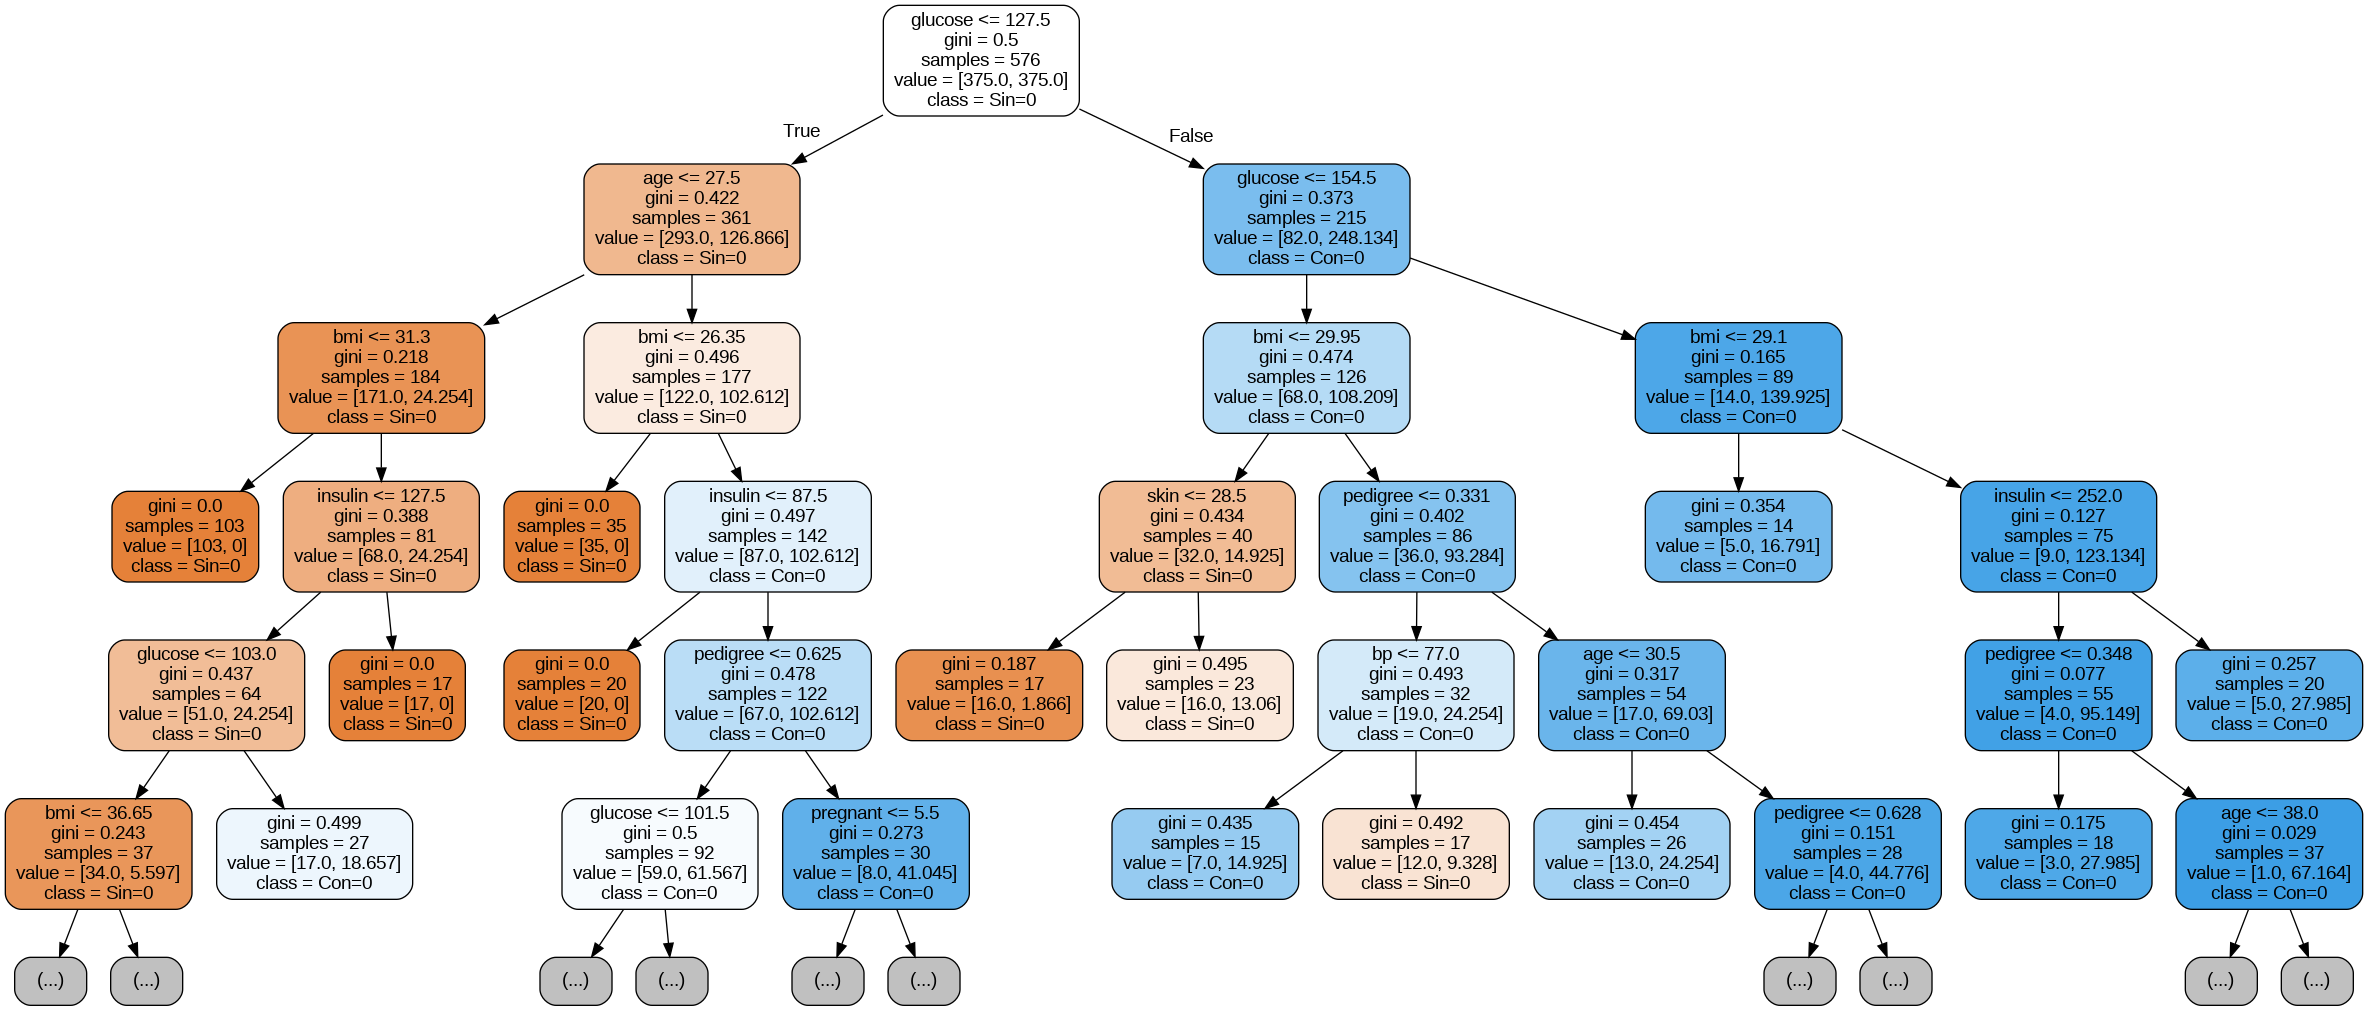

In [30]:
# exportar el modelo a archivo .dot y graficar
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 5,
                              impurity = True,
                              feature_names = list(diabetes.drop(['label'], axis=1)),
                              class_names = ['Sin=0', 'Con=0'],
                              rounded = True,
                              filled= True )

# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

Como se observó en la representación de la importancia de las características, "glucose" tiene la mayor importancia en el modelo. Esto significa que "glucose" es la variable que más influye en la predicción de la etiqueta objetivo (posiblemente la presencia de diabetes).

Al seleccionar "glucose" como nodo raíz, el árbol de decisión puede hacer la primera división más significativa, lo que facilita las divisiones posteriores. Esto no solo mejora la exactitud del modelo, sino que también ayuda a crear un árbol más interpretable y eficiente


# **7. Matriz de confusión del árbol de decisión**

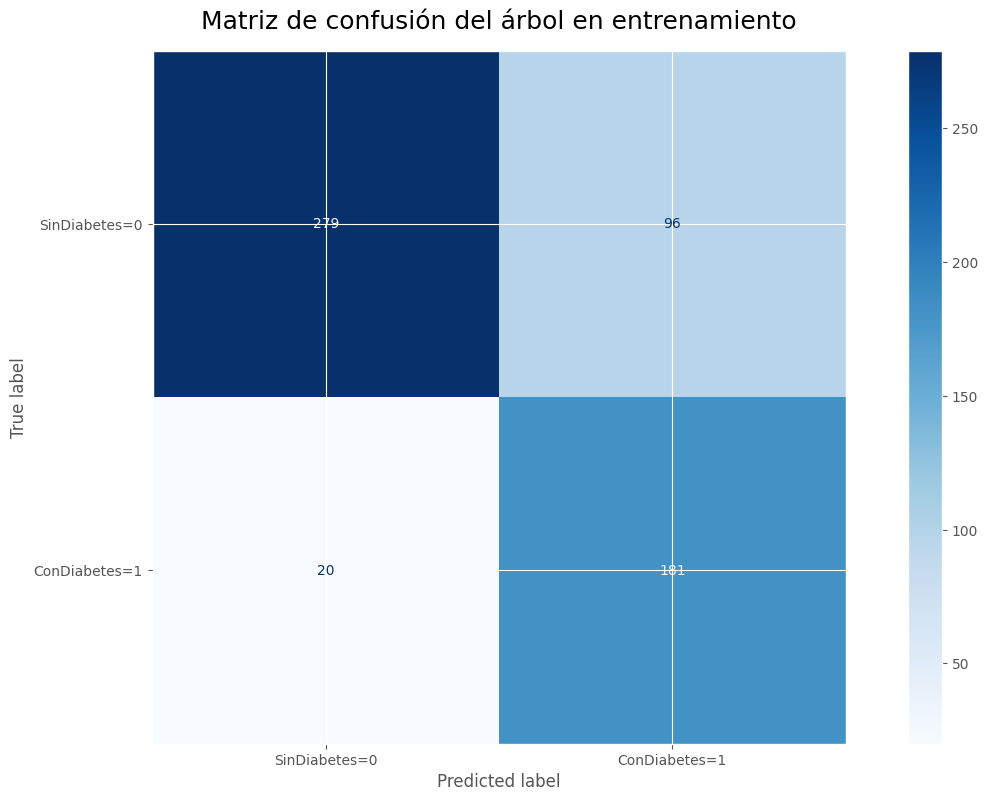

In [31]:
# Matriz de confuncion para Train
y_pred_train = decision_tree.predict(x_train)
cm_train = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=['SinDiabetes=0', 'ConDiabetes=1'])

disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Matriz de confusión del árbol en entrenamiento', y=1.02, size=18)
plt.show()

Se obtiene que 279 casos fueron detectados correctamente como no diabéticos, mientras que 96 pacientes fueron incorrectamente diagnosticados con diabetes. Por otro lado, 20 pacientes fueron diagnosticados sin diabetes aunque tienen la enfermedad y 181 pacientes diabéticos fueron diagnosticados como tal.

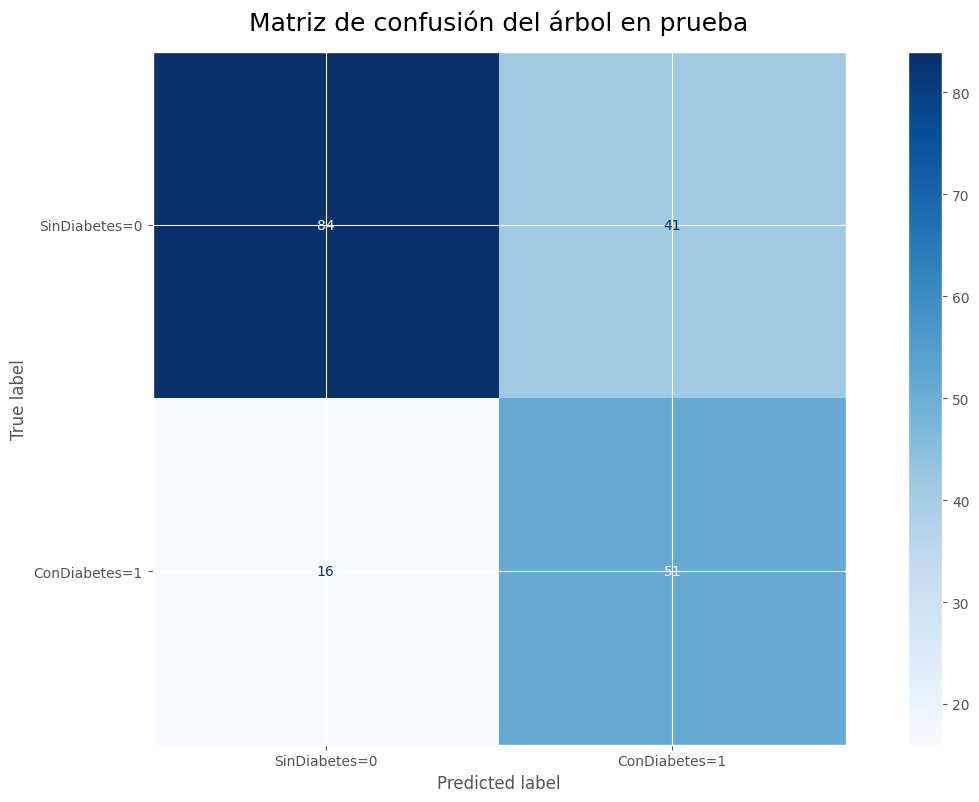

In [32]:
# Matriz de confusión para Test
y_pred_train = decision_tree.predict(x_train)
cm_train = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=['SinDiabetes=0', 'ConDiabetes=1'])

disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Matriz de confusión del árbol en prueba', y=1.02, size=18)
plt.show()

Se obtiene que 51 pacientes fueron detectados correctamente como diabéticos, mientras que 16 fueron incorrectamente diagnosticados con la enfermedad cuando no la tenían. Así mismo, 84 pacientes fueron correctamente identificados como no diabéticos y 41 pacientes no fueron diagnosticados correctamente aunque sí padecen la enfermedad.

#**8. Calcular métrica de exactitud**

In [33]:
y_pred_train = decision_tree.predict(x_train)

In [34]:
# Calcular exactitud en entrenamiento
acc_train = accuracy_score(y_train, y_pred_train)
print("Train set accuracy: {:.2f}".format(acc_train))

Train set accuracy: 0.80


El modelo en entrenamiento tiene una exactitud del 80% en el diágnostico adecuado del padecimiento o no de la enfermedad.

In [35]:
y_pred_test = decision_tree.predict(x_test)

In [36]:
# Calcular exactitud en prueba
acc_test = accuracy_score(y_test, y_pred_test)
print("Train set accuracy: {:.2f}".format(acc_test))

Train set accuracy: 0.70


Mientras que en prueba mantiene una exactitud menor con un valor del 70%.

# **9. Calcular métricas de precisión, sensibilidad (recall) y F1-Score**

### Calcular métricas para entrenamiento (train)

In [37]:
decoded_y_train = y_train
decoded_predictions = decision_tree.predict(x_train)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_train,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.74      0.83       375
           1       0.65      0.90      0.76       201

    accuracy                           0.80       576
   macro avg       0.79      0.82      0.79       576
weighted avg       0.84      0.80      0.80       576



En entrenamiento se observa que el modelo tiene una precisión del 93% para diagnósticos de personas que no padecen la enfermedad y del 65% para pacientes diabéticos.

Por su parte, con un recall de 74% para no diabéticos y 90% para diabéticos, se puede evidenciar que el modelo está mejor entrenado para diagnosticar adecuadamente pacientes que tienen la enfermedad.

Finalmente, se puede afirmar que el modelo tiene dificultades para identificar adecuadamente los casos de diabetes puesto que el F1-Score para este es de 76%, el cual es significativamente menor que para los pacientes no diabéticos que se encuentra en 83%.

### Calcular métricas para prueba (test)

In [38]:
decoded_y_test = y_test
decoded_predictions = decision_tree.predict(x_test)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.67      0.75       125
           1       0.55      0.76      0.64        67

    accuracy                           0.70       192
   macro avg       0.70      0.72      0.69       192
weighted avg       0.74      0.70      0.71       192



En el caso de la validación, se observa que el modelo tiene una precisión del 84% para diagnósticos de personas que no padecen la enfermedad y del 55% para pacientes diabéticos.

Por su parte, con un recall de 67% para no diabéticos y 76% para diabéticos, se puede evidenciar nuevamente que el modelo está mejor entrenado para diagnosticar adecuadamente pacientes que tienen la enfermedad.

De esta manera, se puede evidenciar que al igual que en entrenamiento, el modelo de prueba tiene dificultades para diagnosticar correctamente casos de pacientes diabéticos con un F1-Score de 64% mientras que para pacientes no diabéticos el valor de la métrica es de 75%.

# **10. Técnica de Clasificación Bayesiana**

In [39]:
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    x_train,
    y_train
)
y_pred = gnb.predict(x_test)

print('Precisión de los datos de entrenamiento: {:.2f}'
     .format(gnb.score(x_train, y_train)))
print('Precisión de los datos de prueba {:.2f}'
     .format(gnb.score(x_test, y_test)))

Precisión de los datos de entrenamiento: 0.75
Precisión de los datos de prueba 0.76


**Matriz de confusión para clasificación bayesiana con los datos de entrenamiento.**

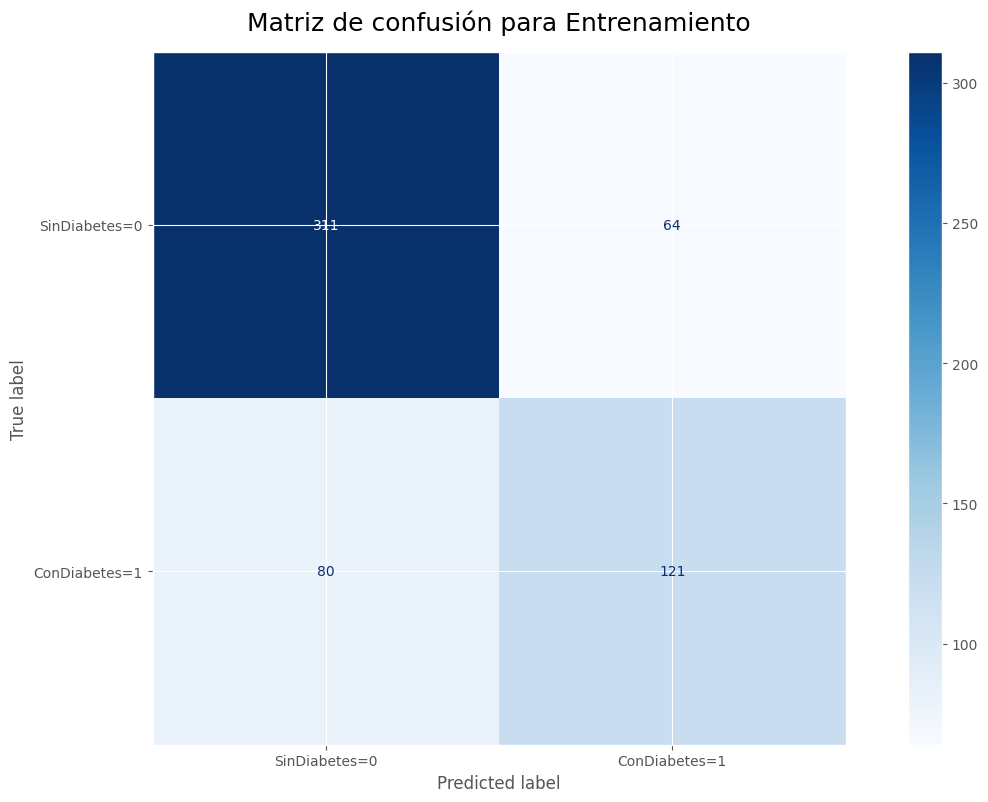

In [40]:
y_pred_train = gnb.predict(x_train)
cm_train = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=['SinDiabetes=0', 'ConDiabetes=1'])

disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Matriz de confusión para Entrenamiento', y=1.02, size=18)
# Mostrar la gráfica
plt.show()

Se obtiene que 121 pacientes fueron detectados correctamente como diabéticos, mientras que 64 fueron incorrectamente diagnosticados con la enfermedad cuando no la tenían. Así mismo, 311 pacientes fueron correctamente identificados como no diabéticos y 80 pacientes no fueron diagnosticados correctamente aunque sí padecen la enfermedad.

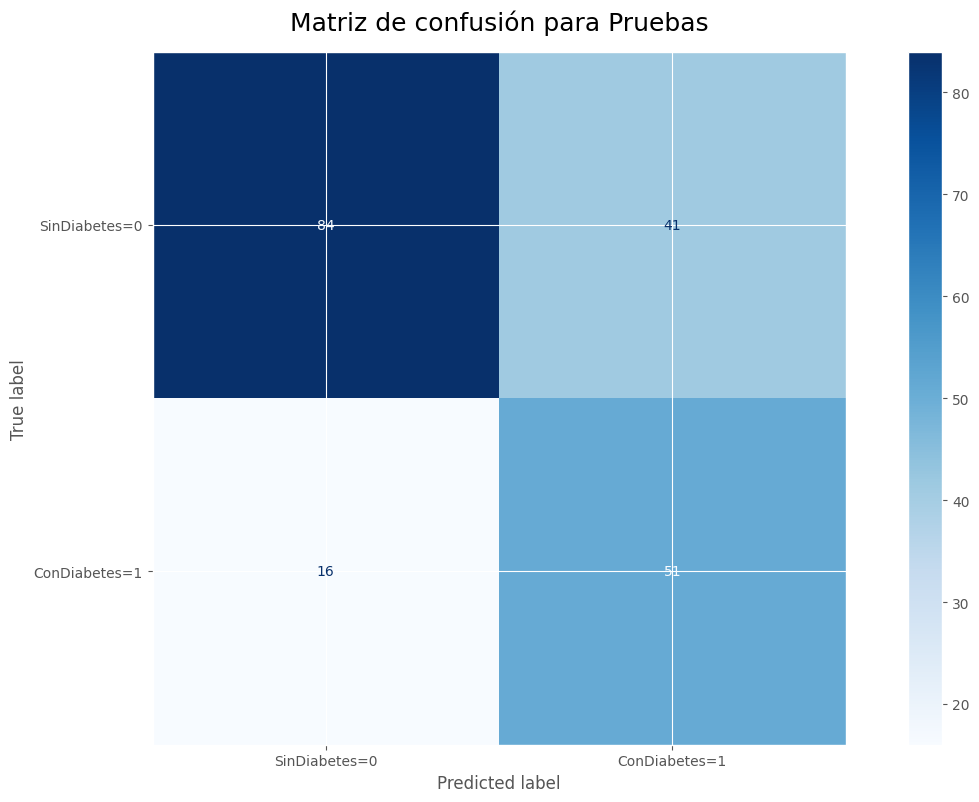

In [41]:
# Matriz de confusión para Test
y_pred_train = gnb.predict(x_train)
cm_train = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                              display_labels=['SinDiabetes=0', 'ConDiabetes=1'])

disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title('Matriz de confusión para Pruebas', y=1.02, size=18)
# Mostrar la gráfica
plt.show()

Se obtiene que 84 casos fueron detectados correctamente como no diabéticos, mientras que 41 pacientes fueron incorrectamente diagnosticados con diabetes. Por otro lado, 16 pacientes fueron diagnosticados sin diabetes aunque tienen la enfermedad y 51 pacientes diabéticos fueron diagnosticados como tal.

### Calcular métricas para entrenamiento (train)

In [42]:
decoded_y_test = y_train
decoded_predictions = gnb.predict(x_train)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       375
           1       0.65      0.60      0.63       201

    accuracy                           0.75       576
   macro avg       0.72      0.72      0.72       576
weighted avg       0.75      0.75      0.75       576



El modelo muestra una precisión del 80% en diagnósticos de personas sin la enfermedad y del 65% para aquellos con diabetes.

Además, con un recall del 83% para no diabéticos y del 60% para diabéticos, se evidencia que el modelo tiene un mejor desempeño en la identificación de pacientes que no padecen la enfermedad.

Por último, se puede afirmar que el modelo identifica adecuadamente los casos de diabetes, ya que el F1-Score para estos pacientes es del 81%, considerablemente mayor que el 63% obtenido para los no diabéticos.

### Calcular métricas para pruebas (test)

In [43]:
decoded_y_test = y_test
decoded_predictions = gnb.predict(x_test)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       125
           1       0.66      0.63      0.64        67

    accuracy                           0.76       192
   macro avg       0.73      0.73      0.73       192
weighted avg       0.75      0.76      0.75       192



En el caso de prueba se observa una precisión del 80% para los diagnósticos de personas que no presentan la enfermedad y del 66% para quienes sí la tienen.

Respecto al recall, el modelo identifica correctamente al 82% de los pacientes sin la enfermedad y al 63% de los pacientes enfermos. Esto sugiere que el modelo tiene un mejor desempeño al identificar correctamente a aquellos que no padecen la enfermedad.

En cuanto al F1-Score, el valor es de 81% para no diabéticos y de 64% para diabéticos, lo que indica que el modelo maneja mejor los diagnósticos de pacientes no enfermos.

## **11. Análisis de resultados y conclusiones**

### Distribución de variables

La mayoría de los valores de glucosa y bp se concentran en rangos específicos, lo que sugiere una distribución normal con algunos valores atípicos.

### Eficiencia de los modelos de clasificación:

Tanto el modelo de clasificación bayesiana como el árbol de decisión mostraron diferentes niveles de precisión, lo que resalta la importancia de seleccionar el modelo adecuado para diferentes tipos de datos y problemas. En general, los modelos fueron capaces de capturar patrones en los datos, pero la precisión varió entre el conjunto de entrenamiento y el de prueba teniendo en ambos casos mayor dificultad para generalizar datos de pacientes diabéticos que no diabéticos, esto puede deberse a la distribución de los datos en ambas categorías.

### Manejo de valores faltantes y preprocesamiento:

El manejo de valores faltantes, reemplazando ceros sospechosos con la mediana, fue una parte esencial del proceso de preprocesamiento. Esto permitió mejorar la calidad de los datos y, en consecuencia, el rendimiento de los modelos. La estandarización de las características también ayudó a mejorar la consistencia del entrenamiento del modelo.

### Aplicabilidad en diagnósticos médicos:

Dado que el conjunto de datos está relacionado con la predicción de la diabetes, la precisión y fiabilidad del modelo son cruciales. Aunque los modelos utilizados son básicos, los resultados obtenidos son un buen punto de partida para aplicaciones médicas, donde la interpretación cuidadosa y la optimización continua del modelo son esenciales para evitar diagnósticos incorrectos.

## **12. Datasets seleccionados**

## CMU Sleep - Aprendizaje supervisado

Contexto del Estudio:
El estudio busca entender cómo los hábitos de sueño de los estudiantes universitarios de primer año están relacionados con su rendimiento académico, medido por su GPA (promedio general de calificaciones). Los participantes fueron estudiantes de tres universidades diferentes: Carnegie Mellon University (CMU), University of Washington (UW), y Notre Dame University (ND).

### Descripción del dataset

El dataset contiene información de 634 estudiantes, cada fila representa a un participante y sus correspondientes datos de sueño y académicos. A través del Fitbit, se identificaron episodios de sueño, clasificando el episodio de sueño más largo entre el mediodía de un día y el mediodía del siguiente como el episodio de sueño principal.

### Variables

subject_id: Identificador único del estudiante.

study: Número de estudio o universidad del estudiante.

cohort: Código del grupo o cohorte del estudiante.

demo_race: Raza del estudiante (subrepresentado = 0, no subrepresentado = 1).

demo_gender: Género del estudiante (masculino = 0, femenino = 1).

demo_firstgen: Primera generación en la universidad (no = 0, sí = 1).

bedtime_mssd: Variabilidad en la hora de dormir, en horas.

TotalSleepTime: Tiempo total de sueño durante la noche principal, en minutos.

midpoint_sleep: Punto medio del sueño, en minutos después de las 11 pm.

frac_nights_with_data: Proporción de noches con datos capturados.

daytime_sleep: Tiempo promedio de sueño diurno, en minutos.

cum_gpa: Promedio de calificaciones acumulado (escala de 4.0).

term_gpa: Promedio de calificaciones al final del semestre (escala de 4.0).

term_units: Número de unidades de curso del semestre.

Zterm_units_ZofZ: Carga académica relativa al promedio del grupo.


In [44]:
# Lectura del dataset
df = pd.read_csv('cmu-sleep.csv')

In [45]:
# Visualizar los primeros datos

df.head()

,subject_id,study,cohort,demo_race,demo_gender,demo_firstgen,bedtime_mssd,TotalSleepTime,midpoint_sleep,frac_nights_with_data,daytime_sleep,cum_gpa,term_gpa,term_units,Zterm_units_ZofZ
0,185,5,lac1,1,1,0,0.116727,432.200000,458.660000,0.862069,24.160000,3.00,3.38,73,4.055294859
1,158,5,lac1,0,1,0,0.141681,391.931035,364.465517,1.000000,13.137931,3.66,2.60,64,2.482534122
2,209,5,lac1,1,1,0,1.529289,344.304348,560.891304,0.793103,14.956522,3.57,3.07,63,2.30778293
3,102,5,lac1,0,1,1,0.130148,392.620690,416.482759,1.000000,54.551724,3.61,3.56,61,1.958280544
4,174,5,lac1,1,1,0,0.130181,423.421053,368.763158,0.655172,10.526316,3.21,4.00,61,1.958280544


## Wine Quality - Aprendizaje no supervisado

### Contexto del Estudio:
Este conjunto de datos se centra en variantes tintas del vino "Vinho Verde" portugués. El objetivo del estudio es analizar cómo diversas propiedades químicas presentes en el vino influyen en su calidad, medida a través de una puntuación sensorial. Este dataset puede utilizarse tanto para tareas de clasificación como de regresión, dado que las clases están ordenadas pero no balanceadas (por ejemplo, hay muchos más vinos de calidad normal que excelentes o deficientes).

### Descripción del dataset:
El dataset incluye información sobre diferentes características fisicoquímicas del vino y su relación con la calidad percibida. Cada fila del dataset representa una muestra de vino, con sus respectivas medidas químicas y la calidad asignada en función de datos sensoriales.

###Variables:
fixed_acidity: Acidez fija, medida en g/dm³.

volatile_acidity: Acidez volátil, medida en g/dm³.

citric_acid: Cantidad de ácido cítrico, medida en g/dm³.

residual_sugar: Azúcar residual, medida en g/dm³.

chlorides: Cantidad de cloruros, medida en g/dm³.

free_sulfur_dioxide: Dióxido de azufre libre, medida en mg/dm³.

total_sulfur_dioxide: Dióxido de azufre total, medida en mg/dm³.

density: Densidad del vino, medida en g/cm³.

pH: Nivel de pH del vino.

sulphates: Sulfatos, medida en g/dm³.

alcohol: Contenido de alcohol, medido en % vol.

quality: Calidad del vino, con una puntuación entre 0 y 10 basada en datos sensoriales.

In [46]:
# Lectura del dataset
df = pd.read_csv('WineQT.csv')

In [47]:
# Visualizar los primeros datos

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4
